In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_auc_score
)

# 1. Load Data
file_path = "preprocessed_stress_level_dataset.csv"

df = pd.read_csv(file_path)


# 2. Define Features (X) and Target (y)
target_column = 'stress_level'


X = df.drop(target_column, axis=1)
y = df[target_column]
class_names = [f'Class {c}' for c in sorted(y.unique())]

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(X.columns)}, Target: {target_column}")
print(f"Target classes: {sorted(y.unique())}\n")

# 3. Split Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}\n")

# 4. Helper function to evaluate models
# This avoids repeating the same print/plot code for every model
def evaluate_model(model, X_test, y_test, model_name):
    print(f"--- Evaluation for: {model_name} ---")

    # Get predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # 1. Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"1. Accuracy: {accuracy:.4f}")

    # 2. Classification Report (Precision, Recall, F1-Score)
    print("\n2. Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 3. AUC Score
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"3. AUC Score (One-vs-Rest): {auc:.4f}")


    # 4. Confusion Matrix
    print("\n4. Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"cm_{model_name.replace(' ', '_').lower()}.png") # Save the plot
    plt.show() # Display the plot

    print("--------------------------------------------------\n")
    return accuracy, y_prob # Return accuracy for comparison

# To store results for final comparison
model_accuracies = {}

Dataset shape: (1100, 13)
Features: 12, Target: stress_level
Target classes: [np.int64(0), np.int64(1), np.int64(2)]

Training set: (880, 12), Test set: (220, 12)



--- Evaluation for: Variation 1: Baseline (Defaults) ---
1. Accuracy: 0.8955

2. Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.85      0.86        74
     Class 1       0.94      0.94      0.94        72
     Class 2       0.88      0.89      0.89        74

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220

3. AUC Score (One-vs-Rest): 0.9750

4. Confusion Matrix:


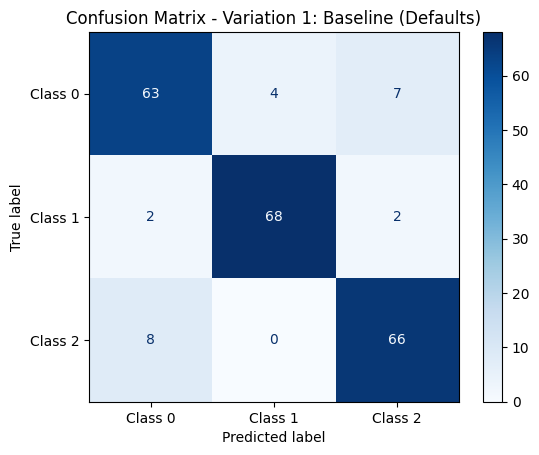

--------------------------------------------------



In [18]:
# --- Variation 1: Baseline Model (Default Parameters) ---
# Using 'auto' for multi_class, 'l2' penalty, C=1.0, and 'lbfgs' solver are common defaults.
model_1 = LogisticRegression(random_state=42, max_iter=2000, multi_class='auto')
model_1.fit(X_train, y_train)
acc1, prob1 = evaluate_model(model_1, X_test, y_test, "Variation 1: Baseline (Defaults)")
model_accuracies["Baseline"] = acc1

--- Evaluation for: Variation 2: L1 (Lasso), C=1.0 ---
1. Accuracy: 0.8955

2. Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.85      0.86        74
     Class 1       0.94      0.94      0.94        72
     Class 2       0.88      0.89      0.89        74

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220

3. AUC Score (One-vs-Rest): 0.9761

4. Confusion Matrix:


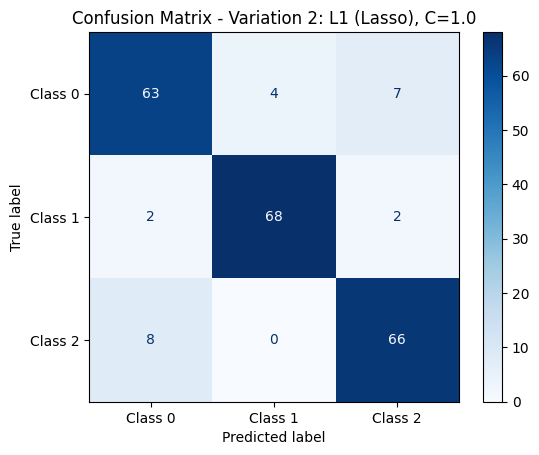

--------------------------------------------------



In [19]:
# --- Variation 2: L1 (Lasso) Regularization ---
# L1 can be used for feature selection. Must use a compatible solver like 'saga'.
# We'll use C=1.0 (standard regularization strength).
model_2 = LogisticRegression(
    random_state=42,
    max_iter=2000,
    multi_class='auto',
    penalty='l1',
    C=1.0,
    solver='saga'
)
model_2.fit(X_train, y_train)
acc2, prob2 = evaluate_model(model_2, X_test, y_test, "Variation 2: L1 (Lasso), C=1.0")
model_accuracies["L1 (Lasso), C=1.0"] = acc2

--- Evaluation for: Variation 3: L2 (Ridge), C=0.1 ---
1. Accuracy: 0.8909

2. Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.88      0.87        74
     Class 1       0.98      0.90      0.94        72
     Class 2       0.85      0.89      0.87        74

    accuracy                           0.89       220
   macro avg       0.90      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220

3. AUC Score (One-vs-Rest): 0.9776

4. Confusion Matrix:


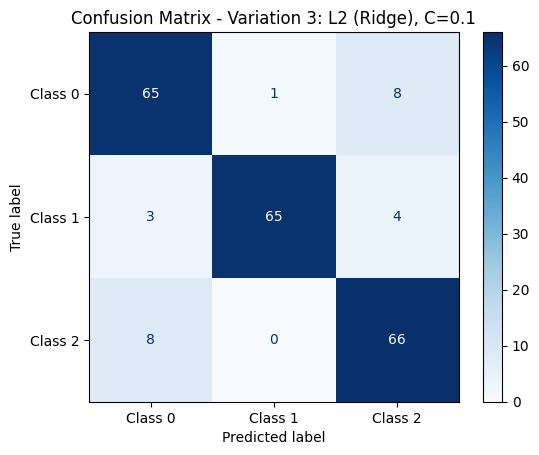

--------------------------------------------------



In [20]:
# --- Variation 3: L2 (Ridge) Regularization (Stronger) ---
# L2 is the default penalty, but we'll use a smaller C (C=0.1).
# A smaller C value means *stronger* regularization.
model_3 = LogisticRegression(
    random_state=42,
    max_iter=2000,
    multi_class='auto',
    penalty='l2',
    C=0.1,
    solver='saga' # Using 'saga' for consistency
)
model_3.fit(X_train, y_train)
acc3, prob3 = evaluate_model(model_3, X_test, y_test, "Variation 3: L2 (Ridge), C=0.1")
model_accuracies["L2 (Ridge), C=0.1"] = acc3


--- Starting Variation 4: GridSearchCV Tuning ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits

GridSearchCV Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
GridSearchCV Best CV Accuracy: 0.8841

--- Evaluation for: Variation 4: GridSearchCV-Tuned ---
1. Accuracy: 0.8864

2. Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.88      0.87        74
     Class 1       0.97      0.90      0.94        72
     Class 2       0.84      0.88      0.86        74

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220

3. AUC Score (One-vs-Rest): 0.9782

4. Confusion Matrix:


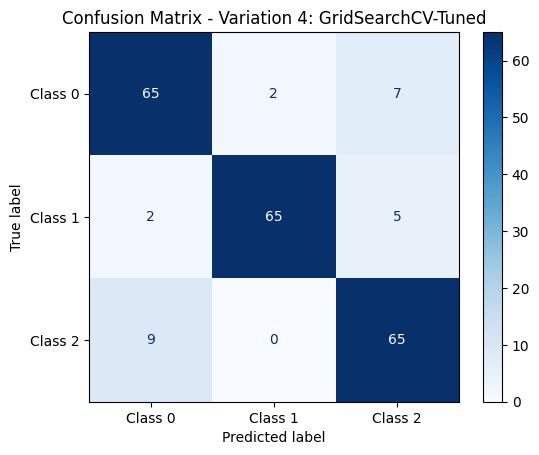

--------------------------------------------------



In [21]:
# --- Variation 4: GridSearchCV Tuned Model ---
print("\n--- Starting Variation 4: GridSearchCV Tuning ---")
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 50],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'] # 'saga' handles both l1 and l2
}
# Base model for grid search
lr_base = LogisticRegression(random_state=42, max_iter=2000, multi_class='auto')

# Set up GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Train the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

print(f"\nGridSearchCV Best Parameters: {grid_search.best_params_}")
print(f"GridSearchCV Best CV Accuracy: {grid_search.best_score_:.4f}\n")

# Evaluate the best model found by GridSearchCV
acc4, prob4 = evaluate_model(best_model, X_test, y_test, "Variation 4: GridSearchCV-Tuned")
model_accuracies["GridSearchCV-Tuned"] = acc4

In [22]:
# --- 6. Final Comparison ---

# Print a summary of accuracies
print("\n--- Final Model Accuracy Comparison ---")
print(pd.Series(model_accuracies).sort_values(ascending=False))




--- Final Model Accuracy Comparison ---
Baseline              0.895455
L1 (Lasso), C=1.0     0.895455
L2 (Ridge), C=0.1     0.890909
GridSearchCV-Tuned    0.886364
dtype: float64
